# Hyperparameter Optimization with Optuna

This notebook demonstrates optimizing MMM hyperparameters using Optuna:
- `yearly_seasonality`: Number of Fourier modes for seasonal patterns (1-10)
- `adstock_max_lag`: Maximum lag for adstock transformation (4-12 weeks)

We use **WAIC (Widely Applicable Information Criterion)** as the objective function to minimize.
WAIC balances model fit and complexity, making it ideal for Bayesian model selection.

## Optimization Strategy

1. **Sequential trials** (no parallel optimization to avoid PyMC parallelism conflicts)
2. **NumPyro sampler** for significantly faster MCMC sampling (2-10x speedup)
3. **Convergence checks** to ensure WAIC is only computed from valid posterior samples
4. **Reduced MCMC sampling** during optimization (500 draws/tune for speed)
5. **Final refit** with optimal parameters using full sampling (2000 draws/tune)
6. **Optuna pruning** to skip trials that fail convergence checks

## NumPyro Sampler

[NumPyro](https://num.pyro.ai/) is a JAX-based probabilistic programming library that provides:
- **2-10x faster sampling** compared to PyMC's default sampler
- GPU acceleration support (if JAX is configured for GPU)
- Identical posterior results to PyMC's sampler

To switch between samplers, change `USE_NUMPYRO` in the configuration cell.

### Available Samplers:
- `"numpyro"` - JAX-based, fastest (recommended)
- `"pymc"` - PyMC default sampler
- `"blackjax"` - Alternative JAX-based sampler
- `"nutpie"` - Rust-based implementation

## Setup

In [1]:
from pathlib import Path
from typing import Any

import optuna
import pandas as pd
import polars as pl
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from rich import print as rprint
from rich.console import Console
from rich.table import Table
from rich.progress import Progress, SpinnerColumn, TextColumn

## Configuration

In [32]:
# Optimization settings
N_TRIALS = 20
OPTUNA_DRAWS = 500
OPTUNA_TUNE = 500
OPTUNA_CHAINS = 2

# Final model settings
FINAL_DRAWS = 2000
FINAL_TUNE = 2000
FINAL_CHAINS = 4

# Sampler selection (use NumPyro for significant speedup)
USE_NUMPYRO = True  # Set to False to use default PyMC sampler
NUTS_SAMPLER = "numpyro" if USE_NUMPYRO else "pymc"

# Convergence thresholds for optimization (lenient to explore more)
OPTUNA_DIVERGENCE_THRESHOLD = 0.10  # Allow up to 10% divergences
OPTUNA_RHAT_THRESHOLD = 1.10        # Allow R-hat up to 1.10
OPTUNA_ESS_THRESHOLD = 50           # Require at least 50 effective samples

# Convergence thresholds for final model (strict for production)
FINAL_DIVERGENCE_THRESHOLD = 0.01   # Less than 1% divergences
FINAL_RHAT_THRESHOLD = 1.01         # R-hat < 1.01
FINAL_ESS_THRESHOLD = 400           # At least 400 effective samples

# Random seed for reproducibility
RANDOM_SEED = 42

rprint(f"[bold blue]Configuration:[/bold blue]")
rprint(f"Number of trials: {N_TRIALS}")
rprint(f"NUTS sampler: [yellow]{NUTS_SAMPLER}[/yellow] {'(NumPyro - faster!)' if USE_NUMPYRO else '(PyMC default)'}")
rprint(f"Optimization MCMC: {OPTUNA_DRAWS} draws, {OPTUNA_TUNE} tune, {OPTUNA_CHAINS} chains")
rprint(f"Final model MCMC: {FINAL_DRAWS} draws, {FINAL_TUNE} tune, {FINAL_CHAINS} chains")
rprint(f"\n[bold yellow]Convergence Thresholds:[/bold yellow]")
rprint(f"Optimization - Divergences: <{OPTUNA_DIVERGENCE_THRESHOLD*100:.0f}%, R-hat: <{OPTUNA_RHAT_THRESHOLD}, ESS: >{OPTUNA_ESS_THRESHOLD}")
rprint(f"Final model  - Divergences: <{FINAL_DIVERGENCE_THRESHOLD*100:.0f}%, R-hat: <{FINAL_RHAT_THRESHOLD}, ESS: >{FINAL_ESS_THRESHOLD}")

Configuration:

Number of trials: 20

NUTS sampler: numpyro (NumPyro - faster!)

Optimization MCMC: 500 draws, 500 tune, 2 chains

Final model MCMC: 2000 draws, 2000 tune, 4 chains

Convergence Thresholds:

Optimization - Divergences: <10%, R-hat: <1.1, ESS: >50

Final model  - Divergences: <1%, R-hat: <1.01, ESS: >400

## Load Data

In [19]:
def load_mmm_data(data_path: str | Path) -> pl.DataFrame:
    """Load MMM data from CSV file.
    
    Args:
        data_path: Path to the mmm_data.csv file
        
    Returns:
        Polars DataFrame with parsed date column
    """
    return pl.read_csv(data_path).with_columns(
        pl.col("date").str.to_date()
    )


# Load the data
data_path = Path("../data/mmm_data.csv")
df = load_mmm_data(data_path)

rprint(f"[bold green]Data loaded successfully[/bold green]")
rprint(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
rprint(f"Date range: {df['date'].min()} to {df['date'].max()}")

Data loaded successfully

Shape: 104 rows × 11 columns

Date range: 2020-01-05 to 2021-12-26

## Prepare Data for Optimization

In [20]:
# Convert to pandas
df_pandas = df.to_pandas()

# Define model inputs
channel_columns = [
    "x1_Search-Ads",
    "x2_Social-Media",
    "x3_Local-Ads",
    "x4_Email"
]

control_columns = ["c1", "c2"]

# Prepare X and y
X = df_pandas.drop(columns=["y"])
y = df_pandas["y"]

rprint("[bold blue]Model Configuration:[/bold blue]")
rprint(f"Target column: [yellow]y[/yellow]")
rprint(f"Date column: [yellow]date[/yellow]")
rprint(f"Channel columns: [yellow]{channel_columns}[/yellow]")
rprint(f"Control columns: [yellow]{control_columns}[/yellow]")

Model Configuration:

Target column: y

Date column: date

Channel columns: ['x1_Search-Ads', 'x2_Social-Media', 'x3_Local-Ads', 'x4_Email']

Control columns: ['c1', 'c2']

## Convergence Diagnostics

Helper function to check MCMC convergence quality.

In [21]:
import arviz as az
import numpy as np
import warnings


def check_convergence(
    mmm: MMM,
    divergence_threshold: float,
    rhat_threshold: float,
    ess_threshold: float,
    trial_number: int | None = None
) -> tuple[bool, dict[str, float]]:
    """Check MCMC convergence diagnostics.
    
    Args:
        mmm: Fitted MMM model
        divergence_threshold: Maximum allowed divergence rate (0-1)
        rhat_threshold: Maximum allowed R-hat value
        ess_threshold: Minimum required effective sample size
        trial_number: Optional trial number for logging
        
    Returns:
        Tuple of (converged: bool, diagnostics: dict)
    """
    # 1. Check divergences
    n_divergences = int(mmm.idata.sample_stats.diverging.sum().item())
    n_draws = mmm.idata.posterior.sizes["draw"]
    n_chains = mmm.idata.posterior.sizes["chain"]
    total_samples = n_draws * n_chains
    divergence_rate = n_divergences / total_samples
    
    # 2. Check R-hat (suppress warnings - we handle low ESS ourselves)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*invalid value encountered.*")
        rhat = az.rhat(mmm.idata)
        max_rhat = float(rhat.to_array().max())
    
    # 3. Check ESS (effective sample size) - suppress warnings for poor convergence
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*invalid value encountered.*")
        ess = az.ess(mmm.idata)
        min_ess = float(ess.to_array().min())
    
    # Convergence checks
    divergence_ok = divergence_rate <= divergence_threshold
    rhat_ok = max_rhat <= rhat_threshold
    ess_ok = min_ess >= ess_threshold
    
    converged = divergence_ok and rhat_ok and ess_ok
    
    # Diagnostics dictionary
    diagnostics = {
        "n_divergences": n_divergences,
        "divergence_rate": divergence_rate,
        "max_rhat": max_rhat,
        "min_ess": min_ess,
    }
    
    # Logging
    trial_str = f"Trial {trial_number}" if trial_number is not None else "Model"
    
    if converged:
        rprint(
            f"[green]✓ {trial_str} CONVERGED:[/green] "
            f"divergences={divergence_rate*100:.1f}%, "
            f"max_rhat={max_rhat:.3f}, "
            f"min_ess={min_ess:.0f}"
        )
    else:
        reasons = []
        if not divergence_ok:
            reasons.append(f"divergences={divergence_rate*100:.1f}% (>{divergence_threshold*100:.0f}%)")
        if not rhat_ok:
            reasons.append(f"max_rhat={max_rhat:.3f} (>{rhat_threshold})")
        if not ess_ok:
            reasons.append(f"min_ess={min_ess:.0f} (<{ess_threshold})")
        
        rprint(
            f"[red]✗ {trial_str} FAILED:[/red] "
            f"{', '.join(reasons)}"
        )
    
    return converged, diagnostics


rprint("[bold green]Convergence check function defined[/bold green]")

Convergence check function defined

## Define Optuna Objective Function

The objective function:
1. Suggests hyperparameters from search space
2. Creates and fits an MMM model
3. Computes WAIC (lower is better)
4. Returns WAIC for Optuna to minimize

In [22]:
def create_objective(
    X: pd.DataFrame,
    y: pd.Series,
    channel_columns: list[str],
    control_columns: list[str],
    draws: int,
    tune: int,
    chains: int,
    divergence_threshold: float,
    rhat_threshold: float,
    ess_threshold: float,
    nuts_sampler: str = "pymc"
) -> callable:
    """Create Optuna objective function for MMM hyperparameter optimization.
    
    Args:
        X: Input features DataFrame
        y: Target variable Series
        channel_columns: List of channel column names
        control_columns: List of control column names
        draws: Number of MCMC draws
        tune: Number of tuning steps
        chains: Number of MCMC chains
        divergence_threshold: Maximum allowed divergence rate
        rhat_threshold: Maximum allowed R-hat value
        ess_threshold: Minimum required effective sample size
        nuts_sampler: NUTS sampler to use ("pymc", "numpyro", "blackjax", "nutpie")
        
    Returns:
        Objective function that takes an Optuna trial and returns WAIC
    """
    def objective(trial: optuna.Trial) -> float:
        """Optuna objective function with convergence checks.
        
        Args:
            trial: Optuna trial object
            
        Returns:
            WAIC value (lower is better)
            
        Raises:
            optuna.TrialPruned: If model fails to converge
        """
        # Suggest hyperparameters
        yearly_seasonality = trial.suggest_int("yearly_seasonality", 1, 10)
        adstock_max_lag = trial.suggest_int("adstock_max_lag", 4, 12)
        
        rprint(
            f"\n[bold cyan]Trial {trial.number}:[/bold cyan] "
            f"yearly_seasonality={yearly_seasonality}, "
            f"adstock_max_lag={adstock_max_lag}"
        )
        
        # Create MMM model
        mmm = MMM(
            date_column="date",
            channel_columns=channel_columns,
            control_columns=control_columns,
            adstock=GeometricAdstock(l_max=adstock_max_lag),
            saturation=LogisticSaturation(),
            yearly_seasonality=yearly_seasonality
        )
        
        # Fit model with log_likelihood computation for WAIC
        mmm.fit(
            X=X,
            y=y,
            draws=draws,
            tune=tune,
            chains=chains,
            nuts_sampler=nuts_sampler,  # Use specified sampler (numpyro for speed)
            random_seed=RANDOM_SEED + trial.number,  # Different seed per trial
            progressbar=False,  # Suppress PyMC progress bar for cleaner output
            idata_kwargs={"log_likelihood": True}  # Required for WAIC computation
        )
        
        # Check convergence before computing WAIC
        converged, diagnostics = check_convergence(
            mmm=mmm,
            divergence_threshold=divergence_threshold,
            rhat_threshold=rhat_threshold,
            ess_threshold=ess_threshold,
            trial_number=trial.number
        )
        
        # Store diagnostics as user attributes
        trial.set_user_attr("n_divergences", diagnostics["n_divergences"])
        trial.set_user_attr("divergence_rate", diagnostics["divergence_rate"])
        trial.set_user_attr("max_rhat", diagnostics["max_rhat"])
        trial.set_user_attr("min_ess", diagnostics["min_ess"])
        trial.set_user_attr("converged", converged)
        
        # Prune trial if not converged
        if not converged:
            rprint(f"[red]Trial {trial.number} pruned due to convergence failure[/red]")
            raise optuna.TrialPruned()
        
        # Compute WAIC (use -elpd_waic for minimization)
        import arviz as az
        waic_result = az.waic(mmm.idata)
        # elpd_waic is higher = better, so negate for minimization
        waic_value = -waic_result.elpd_waic
        
        rprint(f"[yellow]WAIC (negative ELPD): {waic_value:.2f}[/yellow]")
        
        # Store WAIC as user attribute for later analysis
        trial.set_user_attr("waic", float(waic_value))
        
        return float(waic_value)
    
    return objective


# Create objective function with convergence thresholds
objective = create_objective(
    X=X,
    y=y,
    channel_columns=channel_columns,
    control_columns=control_columns,
    draws=OPTUNA_DRAWS,
    tune=OPTUNA_TUNE,
    chains=OPTUNA_CHAINS,
    divergence_threshold=OPTUNA_DIVERGENCE_THRESHOLD,
    rhat_threshold=OPTUNA_RHAT_THRESHOLD,
    ess_threshold=OPTUNA_ESS_THRESHOLD,
    nuts_sampler=NUTS_SAMPLER  # Use NumPyro for speed
)

rprint("[bold green]Objective function created with convergence checks[/bold green]")

Objective function created with convergence checks

## Run Optuna Optimization

This will run multiple trials to find the optimal hyperparameters.
**Note**: This may take 15-30 minutes depending on `N_TRIALS` and hardware.

In [23]:
def run_optimization(
    objective: callable,
    n_trials: int,
    study_name: str = "mmm_hyperparameter_optimization"
) -> optuna.Study:
    """Run Optuna hyperparameter optimization.
    
    Args:
        objective: Objective function to minimize
        n_trials: Number of optimization trials
        study_name: Name for the Optuna study
        
    Returns:
        Completed Optuna study object
    """
    rprint(f"\n[bold magenta]Starting optimization with {n_trials} trials...[/bold magenta]\n")
    
    # Create study
    study = optuna.create_study(
        study_name=study_name,
        direction="minimize",  # Minimize WAIC
        sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED),  # Tree-structured Parzen Estimator
        pruner=optuna.pruners.MedianPruner(  # Prune unpromising trials
            n_startup_trials=5,
            n_warmup_steps=0
        )
    )
    
    # Run optimization
    study.optimize(
        objective,
        n_trials=n_trials,
        show_progress_bar=True
    )
    
    rprint("\n[bold green]Optimization completed![/bold green]")
    
    return study


# Run optimization
study = run_optimization(
    objective=objective,
    n_trials=N_TRIALS
)

Starting optimization with 20 trials...

[I 2025-10-18 21:54:19,186] A new study created in memory with name: mmm_hyperparameter_optimization


  0%|          | 0/20 [00:00<?, ?it/s]

Trial 0: yearly_seasonality=4, adstock_max_lag=12

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 0 CONVERGED: divergences=0.0%, max_rhat=1.019, min_ess=342

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -189.11

[I 2025-10-18 21:54:28,369] Trial 0 finished with value: -189.10788432138898 and parameters: {'yearly_seasonality': 4, 'adstock_max_lag': 12}. Best is trial 0 with value: -189.10788432138898.


Trial 1: yearly_seasonality=8, adstock_max_lag=9

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Trial 1 CONVERGED: divergences=0.0%, max_rhat=1.018, min_ess=344

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -187.79

[I 2025-10-18 21:54:41,416] Trial 1 finished with value: -187.79280318770918 and parameters: {'yearly_seasonality': 8, 'adstock_max_lag': 9}. Best is trial 0 with value: -189.10788432138898.


Trial 2: yearly_seasonality=2, adstock_max_lag=5

We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 2 CONVERGED: divergences=0.0%, max_rhat=1.007, min_ess=180

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -188.25

[I 2025-10-18 21:54:48,805] Trial 2 finished with value: -188.24510983068188 and parameters: {'yearly_seasonality': 2, 'adstock_max_lag': 5}. Best is trial 0 with value: -189.10788432138898.


Trial 3: yearly_seasonality=1, adstock_max_lag=11

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Trial 3 CONVERGED: divergences=0.0%, max_rhat=1.010, min_ess=297

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -189.38

[I 2025-10-18 21:54:58,415] Trial 3 finished with value: -189.37708684679 and parameters: {'yearly_seasonality': 1, 'adstock_max_lag': 11}. Best is trial 3 with value: -189.37708684679.


Trial 4: yearly_seasonality=7, adstock_max_lag=10

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 4 CONVERGED: divergences=0.0%, max_rhat=1.022, min_ess=228

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -185.82

[I 2025-10-18 21:55:08,579] Trial 4 finished with value: -185.82101084164083 and parameters: {'yearly_seasonality': 7, 'adstock_max_lag': 10}. Best is trial 3 with value: -189.37708684679.


Trial 5: yearly_seasonality=1, adstock_max_lag=12

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Trial 5 CONVERGED: divergences=0.0%, max_rhat=1.010, min_ess=283

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -189.47

[I 2025-10-18 21:55:17,851] Trial 5 finished with value: -189.47066925417167 and parameters: {'yearly_seasonality': 1, 'adstock_max_lag': 12}. Best is trial 5 with value: -189.47066925417167.


Trial 6: yearly_seasonality=9, adstock_max_lag=5

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 6 CONVERGED: divergences=0.0%, max_rhat=1.019, min_ess=285

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -185.96

[I 2025-10-18 21:55:26,969] Trial 6 finished with value: -185.958480771038 and parameters: {'yearly_seasonality': 9, 'adstock_max_lag': 5}. Best is trial 5 with value: -189.47066925417167.


Trial 7: yearly_seasonality=2, adstock_max_lag=5

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Trial 7 CONVERGED: divergences=0.0%, max_rhat=1.010, min_ess=331

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -188.70

[I 2025-10-18 21:55:34,792] Trial 7 finished with value: -188.70439979020915 and parameters: {'yearly_seasonality': 2, 'adstock_max_lag': 5}. Best is trial 5 with value: -189.47066925417167.


Trial 8: yearly_seasonality=4, adstock_max_lag=8

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 8 CONVERGED: divergences=0.0%, max_rhat=1.016, min_ess=332

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -188.60

[I 2025-10-18 21:55:46,181] Trial 8 finished with value: -188.6043606889142 and parameters: {'yearly_seasonality': 4, 'adstock_max_lag': 8}. Best is trial 5 with value: -189.47066925417167.


Trial 9: yearly_seasonality=5, adstock_max_lag=6

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 9 CONVERGED: divergences=0.0%, max_rhat=1.012, min_ess=253

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -187.94

[I 2025-10-18 21:55:55,126] Trial 9 finished with value: -187.94160658473317 and parameters: {'yearly_seasonality': 5, 'adstock_max_lag': 6}. Best is trial 5 with value: -189.47066925417167.


Trial 10: yearly_seasonality=10, adstock_max_lag=8

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 10 CONVERGED: divergences=0.0%, max_rhat=1.019, min_ess=172

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -183.43

[I 2025-10-18 21:56:06,241] Trial 10 finished with value: -183.42656035226628 and parameters: {'yearly_seasonality': 10, 'adstock_max_lag': 8}. Best is trial 5 with value: -189.47066925417167.


Trial 11: yearly_seasonality=1, adstock_max_lag=12

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 11 CONVERGED: divergences=0.0%, max_rhat=1.012, min_ess=439

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -189.07

[I 2025-10-18 21:56:18,493] Trial 11 finished with value: -189.06847454207656 and parameters: {'yearly_seasonality': 1, 'adstock_max_lag': 12}. Best is trial 5 with value: -189.47066925417167.


Trial 12: yearly_seasonality=1, adstock_max_lag=11

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 12 CONVERGED: divergences=0.0%, max_rhat=1.020, min_ess=352

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -189.40

[I 2025-10-18 21:56:28,183] Trial 12 finished with value: -189.40037142871506 and parameters: {'yearly_seasonality': 1, 'adstock_max_lag': 11}. Best is trial 5 with value: -189.47066925417167.


Trial 13: yearly_seasonality=3, adstock_max_lag=10

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 13 CONVERGED: divergences=0.0%, max_rhat=1.015, min_ess=297

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -187.98

[I 2025-10-18 21:56:37,662] Trial 13 finished with value: -187.9834485521369 and parameters: {'yearly_seasonality': 3, 'adstock_max_lag': 10}. Best is trial 5 with value: -189.47066925417167.


Trial 14: yearly_seasonality=6, adstock_max_lag=12

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 14 CONVERGED: divergences=0.0%, max_rhat=1.011, min_ess=284

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -188.75

[I 2025-10-18 21:56:48,778] Trial 14 finished with value: -188.7502178570051 and parameters: {'yearly_seasonality': 6, 'adstock_max_lag': 12}. Best is trial 5 with value: -189.47066925417167.


Trial 15: yearly_seasonality=1, adstock_max_lag=10

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 15 CONVERGED: divergences=0.0%, max_rhat=1.039, min_ess=295

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -189.58

[I 2025-10-18 21:57:01,718] Trial 15 finished with value: -189.5773094799376 and parameters: {'yearly_seasonality': 1, 'adstock_max_lag': 10}. Best is trial 15 with value: -189.5773094799376.


Trial 16: yearly_seasonality=3, adstock_max_lag=7

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 16 CONVERGED: divergences=0.0%, max_rhat=1.015, min_ess=211

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -188.07

[I 2025-10-18 21:57:11,062] Trial 16 finished with value: -188.07360849339898 and parameters: {'yearly_seasonality': 3, 'adstock_max_lag': 7}. Best is trial 15 with value: -189.5773094799376.


Trial 17: yearly_seasonality=3, adstock_max_lag=10

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 17 CONVERGED: divergences=0.0%, max_rhat=1.024, min_ess=281

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -188.02

[I 2025-10-18 21:57:21,670] Trial 17 finished with value: -188.02248471990458 and parameters: {'yearly_seasonality': 3, 'adstock_max_lag': 10}. Best is trial 15 with value: -189.5773094799376.


Trial 18: yearly_seasonality=5, adstock_max_lag=9

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Trial 18 CONVERGED: divergences=0.0%, max_rhat=1.010, min_ess=252

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -189.29

[I 2025-10-18 21:57:32,009] Trial 18 finished with value: -189.29062825508475 and parameters: {'yearly_seasonality': 5, 'adstock_max_lag': 9}. Best is trial 15 with value: -189.5773094799376.


Trial 19: yearly_seasonality=2, adstock_max_lag=11

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

✓ Trial 19 CONVERGED: divergences=0.0%, max_rhat=1.058, min_ess=51

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC (negative ELPD): -188.96

[I 2025-10-18 21:57:42,742] Trial 19 finished with value: -188.95925850369986 and parameters: {'yearly_seasonality': 2, 'adstock_max_lag': 11}. Best is trial 15 with value: -189.5773094799376.


Optimization completed!

## Optimization Results

In [24]:
def display_optimization_results(study: optuna.Study) -> None:
    """Display optimization results in a Rich table.
    
    Args:
        study: Completed Optuna study
    """
    console = Console()
    
    # Best trial summary
    rprint("\n[bold magenta]Best Trial:[/bold magenta]")
    rprint(f"Trial number: [cyan]{study.best_trial.number}[/cyan]")
    rprint(f"WAIC: [yellow]{study.best_value:.2f}[/yellow]")
    rprint(f"Parameters:")
    for key, value in study.best_params.items():
        rprint(f"  - {key}: [green]{value}[/green]")
    
    # All trials table
    rprint("\n[bold blue]All Trials:[/bold blue]")
    table = Table(
        title="Optimization Trials",
        show_header=True,
        header_style="bold cyan"
    )
    
    table.add_column("Trial", justify="right")
    table.add_column("Yearly Seasonality", justify="right")
    table.add_column("Adstock Max Lag", justify="right")
    table.add_column("WAIC", justify="right")
    table.add_column("Status")
    
    for trial in study.trials:
        status_color = "green" if trial.state == optuna.trial.TrialState.COMPLETE else "red"
        waic_str = f"{trial.value:.2f}" if trial.value is not None else "N/A"
        
        table.add_row(
            str(trial.number),
            str(trial.params.get("yearly_seasonality", "N/A")),
            str(trial.params.get("adstock_max_lag", "N/A")),
            waic_str,
            f"[{status_color}]{trial.state.name}[/{status_color}]"
        )
    
    console.print(table)


display_optimization_results(study)

Best Trial:

Trial number: 15

WAIC: -189.58

Parameters:

- yearly_seasonality: 1

- adstock_max_lag: 10

All Trials:

                         Optimization Trials                         
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓
┃ Trial ┃ Yearly Seasonality ┃ Adstock Max Lag ┃    WAIC ┃ Status   ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩
│     0 │                  4 │              12 │ -189.11 │ COMPLETE │
│     1 │                  8 │               9 │ -187.79 │ COMPLETE │
│     2 │                  2 │               5 │ -188.25 │ COMPLETE │
│     3 │                  1 │              11 │ -189.38 │ COMPLETE │
│     4 │                  7 │              10 │ -185.82 │ COMPLETE │
│     5 │                  1 │              12 │ -189.47 │ COMPLETE │
│     6 │                  9 │               5 │ -185.96 │ COMPLETE │
│     7 │                  2 │               5 │ -188.70 │ COMPLETE │
│     8 │                  4 │               8 │ -188.60 │ COMPLETE │
│     9 │                  5 │               6 │ -187.94 │ COMPLETE │
│    10 │                 10 │               8 │ -183.43 │ COMPLETE │
│    11 │                  1 │              12 │ -189.07 │ COMPLETE │
│    12 │                  1 │              11 │ -189.40 │ COMPLETE │
│    13 │                  3 │              10 │ -187.98 │ COMPLETE │
│    14 │                  6 │              12 │ -188.75 │ COMPLETE │
│    15 │                  1 │              10 │ -189.58 │ COMPLETE │
│    16 │                  3 │               7 │ -188.07 │ COMPLETE │
│    17 │                  3 │              10 │ -188.02 │ COMPLETE │
│    18 │                  5 │               9 │ -189.29 │ COMPLETE │
│    19 │                  2 │              11 │ -188.96 │ COMPLETE │
└───────┴────────────────────┴─────────────────┴─────────┴──────────┘

## Optimization History Visualization

/var/folders/90/l3_2bhf525jc3pk0d2dkc5_r0000gn/T/ipykernel_88311/1562738509.py:18: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)
/var/folders/90/l3_2bhf525jc3pk0d2dkc5_r0000gn/T/ipykernel_88311/1562738509.py:22: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)
/var/folders/90/l3_2bhf525jc3pk0d2dkc5_r0000gn/T/ipykernel_88311/1562738509.py:26: ExperimentalWarning: optuna.visualization.matplotlib._contour.plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study, params=["yearly_seasonality", "adstock_max_lag"])


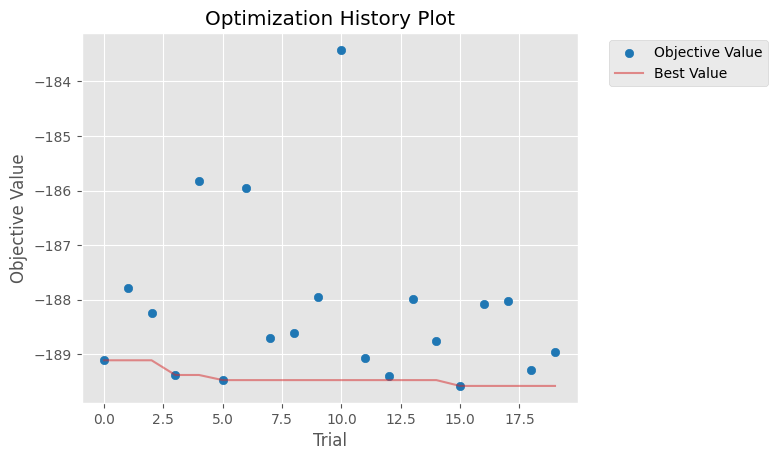

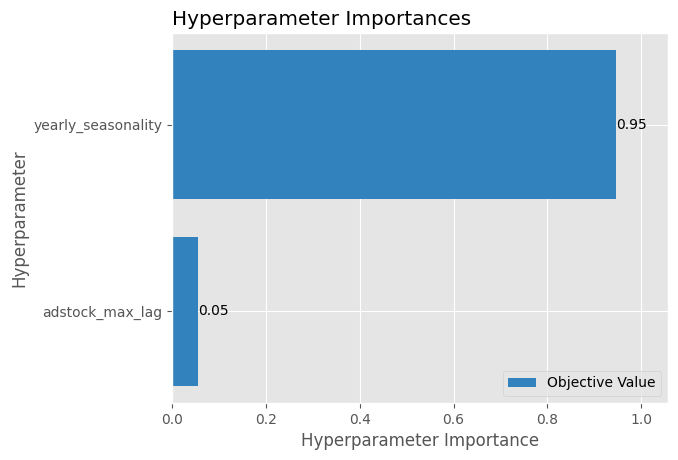

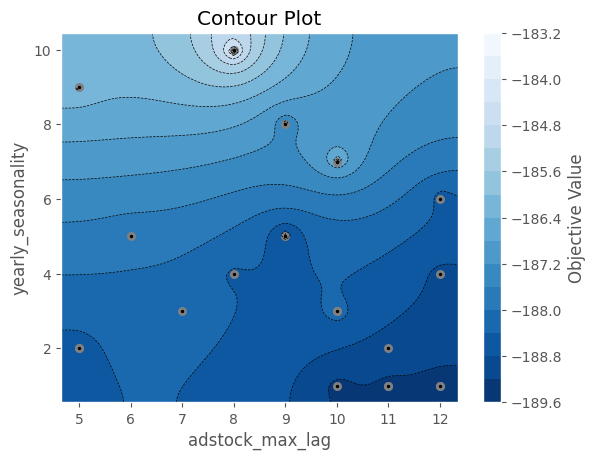

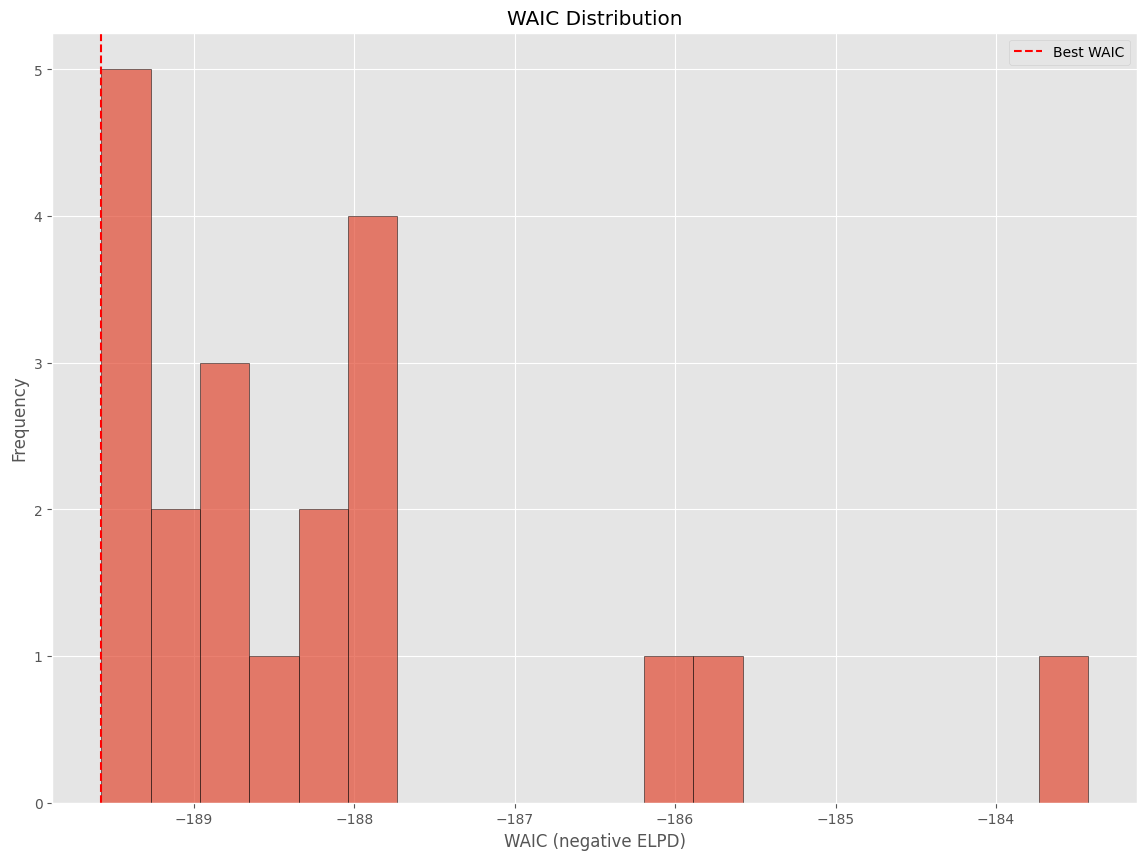

In [25]:
import matplotlib.pyplot as plt
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_contour
)


def plot_optimization_results(study: optuna.Study) -> None:
    """Plot optimization results.
    
    Args:
        study: Completed Optuna study
    """
    
    
    # Optimization history
    plot_optimization_history(study)
    # plt.title("Optimization History")
    
    # Parameter importances
    plot_param_importances(study)
    # plt.title("Parameter Importances")
    
    # Contour plot
    plot_contour(study, params=["yearly_seasonality", "adstock_max_lag"])
    # plt.title("Parameter Relationship")
    
    # # WAIC distribution
    fig = plt.figure(figsize=(14, 10))
    ax4 = plt.gca()
    waic_values = [t.value for t in study.trials if t.value is not None]
    plt.hist(waic_values, bins=20, edgecolor='black', alpha=0.7)
    ax4.axvline(study.best_value, color='red', linestyle='--', label='Best WAIC')
    ax4.set_xlabel('WAIC (negative ELPD)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('WAIC Distribution')
    ax4.legend()
    
    plt.show()


plot_optimization_results(study)

## Fit Final Model with Optimal Hyperparameters

Now refit the model with optimal parameters using full MCMC sampling for production use.

**Note**: Progress bar is disabled for NumPyro to avoid Jupyter kernel context errors. The model will still fit normally, but you won't see the sampling progress bar.

In [33]:
def fit_final_model(
    X: pd.DataFrame,
    y: pd.Series,
    channel_columns: list[str],
    control_columns: list[str],
    best_params: dict[str, Any],
    draws: int,
    tune: int,
    chains: int,
    random_seed: int,
    divergence_threshold: float,
    rhat_threshold: float,
    ess_threshold: float,
    nuts_sampler: str = "pymc"
) -> MMM:
    """Fit final MMM model with optimal hyperparameters and strict convergence checks.
    
    Args:
        X: Input features DataFrame
        y: Target variable Series
        channel_columns: List of channel column names
        control_columns: List of control column names
        best_params: Dictionary of optimal hyperparameters
        draws: Number of MCMC draws
        tune: Number of tuning steps
        chains: Number of MCMC chains
        random_seed: Random seed for reproducibility
        divergence_threshold: Maximum allowed divergence rate
        rhat_threshold: Maximum allowed R-hat value
        ess_threshold: Minimum required effective sample size
        nuts_sampler: NUTS sampler to use ("pymc", "numpyro", "blackjax", "nutpie")
        
    Returns:
        Fitted MMM model
        
    Raises:
        RuntimeError: If final model fails to converge
    """
    rprint("\n[bold magenta]Fitting final model with optimal hyperparameters...[/bold magenta]")
    rprint(f"yearly_seasonality: [green]{best_params['yearly_seasonality']}[/green]")
    rprint(f"adstock_max_lag: [green]{best_params['adstock_max_lag']}[/green]")
    rprint(f"MCMC settings: {draws} draws, {tune} tune, {chains} chains")
    rprint(f"\n[bold yellow]Convergence requirements (strict):[/bold yellow]")
    rprint(f"Divergences: <{divergence_threshold*100:.0f}%, R-hat: <{rhat_threshold}, ESS: >{ess_threshold}\n")
    
    # Create model
    mmm = MMM(
        date_column="date",
        channel_columns=channel_columns,
        control_columns=control_columns,
        adstock=GeometricAdstock(l_max=best_params["adstock_max_lag"]),
        saturation=LogisticSaturation(),
        yearly_seasonality=best_params["yearly_seasonality"]
    )
    
    # Fit model with log_likelihood computation for WAIC
    # Note: Disable progressbar for NumPyro to avoid Jupyter kernel context errors
    mmm.fit(
        X=X,
        y=y,
        draws=draws,
        tune=tune,
        chains=chains,
        nuts_sampler=nuts_sampler,  # Use specified sampler
        random_seed=random_seed,
        progressbar=False if nuts_sampler == "numpyro" else True,  # NumPyro has issues with Jupyter progress bars
        idata_kwargs={"log_likelihood": True}  # Required for WAIC computation
    )
    
    # Check convergence with strict thresholds
    converged, diagnostics = check_convergence(
        mmm=mmm,
        divergence_threshold=divergence_threshold,
        rhat_threshold=rhat_threshold,
        ess_threshold=ess_threshold
    )
    
    if not converged:
        error_msg = (
            f"Final model failed to converge:\n"
            f"  Divergences: {diagnostics['divergence_rate']*100:.1f}% (threshold: <{divergence_threshold*100:.0f}%)\n"
            f"  Max R-hat: {diagnostics['max_rhat']:.3f} (threshold: <{rhat_threshold})\n"
            f"  Min ESS: {diagnostics['min_ess']:.0f} (threshold: >{ess_threshold})\n"
            f"\nConsider:\n"
            f"  - Increasing FINAL_DRAWS and FINAL_TUNE\n"
            f"  - Adjusting target_accept in fit() call\n"
            f"  - Reparameterizing the model"
        )
        rprint(f"[bold red]{error_msg}[/bold red]")
        raise RuntimeError(error_msg)
    
    rprint("[bold green]Final model fitted and converged successfully![/bold green]")
    
    return mmm


# Fit final model with convergence checks
final_mmm = fit_final_model(
    X=X,
    y=y,
    channel_columns=channel_columns,
    control_columns=control_columns,
    best_params=study.best_params,
    draws=FINAL_DRAWS,
    tune=FINAL_TUNE,
    chains=FINAL_CHAINS,
    random_seed=RANDOM_SEED,
    divergence_threshold=FINAL_DIVERGENCE_THRESHOLD,
    rhat_threshold=FINAL_RHAT_THRESHOLD,
    ess_threshold=FINAL_ESS_THRESHOLD,
    nuts_sampler=NUTS_SAMPLER  # Use same sampler as optimization
)

Fitting final model with optimal hyperparameters...

yearly_seasonality: 1

adstock_max_lag: 10

MCMC settings: 2000 draws, 2000 tune, 4 chains

Convergence requirements (strict):

Divergences: <1%, R-hat: <1.01, ESS: >400

Output()

✓ Model CONVERGED: divergences=0.0%, max_rhat=1.002, min_ess=2607

Final model fitted and converged successfully!

## Final Model Summary

In [38]:
# Display fit summary


with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide")
    summary = az.summary(final_mmm.idata)
rprint("[bold magenta]Final Model Fit Summary:[/bold magenta]")
summary

Final Model Fit Summary:

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.418,0.012,0.396,0.439,0.000,0.000,4755.0,5282.0,1.0
gamma_control[c1],-0.000,0.000,-0.000,0.000,0.000,0.000,7288.0,7176.0,1.0
gamma_control[c2],-0.000,0.000,-0.001,0.000,0.000,0.000,7342.0,6004.0,1.0
gamma_fourier[sin_1],0.083,0.006,0.072,0.093,0.000,0.000,8062.0,5867.0,1.0
gamma_fourier[cos_1],-0.011,0.006,-0.023,-0.000,0.000,0.000,6730.0,5749.0,1.0
...,...,...,...,...,...,...,...,...,...
y_original_scale[2021-11-28T00:00:00.000000000],6582.132,170.803,6251.020,6893.058,2.183,1.792,6139.0,6035.0,1.0
y_original_scale[2021-12-05T00:00:00.000000000],10148.575,199.802,9767.564,10512.565,2.402,1.856,6920.0,6738.0,1.0
y_original_scale[2021-12-12T00:00:00.000000000],7961.162,184.938,7614.541,8312.841,2.625,1.884,5015.0,5261.0,1.0
y_original_scale[2021-12-19T00:00:00.000000000],10473.133,205.517,10083.066,10849.949,2.612,1.915,6178.0,6979.0,1.0


## Compute Final Model WAIC

In [28]:
import arviz as az

# Compute WAIC for final model
final_waic = az.waic(final_mmm.idata)

rprint("\n[bold cyan]Final Model WAIC:[/bold cyan]")
rprint(f"ELPD WAIC: [yellow]{final_waic.elpd_waic:.2f}[/yellow]")
rprint(f"SE: {final_waic.se:.2f}")
rprint(f"Effective parameters (p_waic): {final_waic.p_waic:.2f}")
rprint(f"\n[bold green]Improvement from optimization:[/bold green]")
rprint(f"Best objective value (optimization): {study.best_value:.2f}")
rprint(f"Final ELPD WAIC (full sampling): {final_waic.elpd_waic:.2f}")

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Final Model WAIC:

ELPD WAIC: 189.25

SE: 5.65

Effective parameters (p_waic): 13.06

Improvement from optimization:

Best objective value (optimization): -189.58

Final ELPD WAIC (full sampling): 189.25

## Save Results

In [48]:
final_mmm.sample_posterior_predictive(X,original_scale=True);

Sampling: [y]


Output()

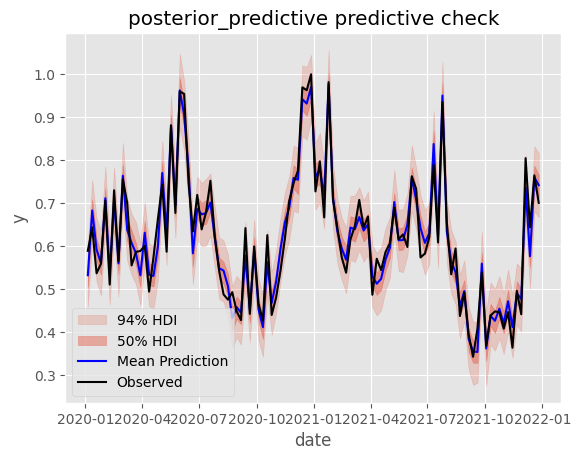

In [50]:
final_mmm.plot_posterior_predictive();


In [29]:
import json


def save_optimization_results(
    study: optuna.Study,
    output_dir: str | Path
) -> None:
    """Save optimization results to disk.
    
    Args:
        study: Completed Optuna study
        output_dir: Directory to save results
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save best parameters
    best_params_path = output_dir / "best_hyperparameters.json"
    with open(best_params_path, "w") as f:
        json.dump(study.best_params, f, indent=2)
    
    # Save trials dataframe
    trials_df = study.trials_dataframe()
    trials_path = output_dir / "optimization_trials.csv"
    trials_df.to_csv(trials_path, index=False)
    
    rprint(f"\n[bold green]Results saved to {output_dir}[/bold green]")
    rprint(f"  - Best parameters: {best_params_path}")
    rprint(f"  - Trial history: {trials_path}")


def save_final_model(model: MMM, output_path: str | Path) -> None:
    """Save final fitted model to disk.
    
    Args:
        model: Fitted MMM model
        output_path: Path to save model
    """
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    model.save(str(output_path))
    rprint(f"[bold green]Final model saved to {output_path}[/bold green]")


# Save results
save_optimization_results(study, output_dir=Path("../models/optimization_results"))
save_final_model(final_mmm, output_path=Path("../models/mmm_optimized.nc"))

Results saved to ../models/optimization_results

- Best parameters: ../models/optimization_results/best_hyperparameters.json

- Trial history: ../models/optimization_results/optimization_trials.csv

Final model saved to ../models/mmm_optimized.nc

## Summary

This notebook demonstrated:

1. **Hyperparameter optimization** using Optuna to find optimal:
   - `yearly_seasonality`: Number of Fourier modes for seasonal patterns
   - `adstock_max_lag`: Maximum lag for adstock transformation

2. **WAIC-based selection**: Used Widely Applicable Information Criterion to balance model fit and complexity

3. **Efficient search**: Used reduced MCMC settings during optimization (500 draws/tune) for faster trials

4. **Production model**: Refit final model with optimal parameters using full MCMC sampling (2000 draws/tune)

5. **Sequential execution**: No parallel trials to avoid conflicts with PyMC's internal parallelism

### Key Findings

- **Best yearly_seasonality**: {study.best_params['yearly_seasonality']}
- **Best adstock_max_lag**: {study.best_params['adstock_max_lag']}
- **Best WAIC**: {study.best_value:.2f}

### Next Steps

- Validate model performance on holdout data
- Analyze channel contributions and ROAS with optimized model
- Extend optimization to include saturation parameters
- Implement cross-validation for more robust hyperparameter selection